In [3]:
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
from pprint import pprint

from earthpy.spatial import stack as es_stack
import xarray as xr

import pickle

# aggregating
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import block_reduce

# mapping
import cartopy
import cartopy.crs as ccrs

from matplotlib import colors
import matplotlib.gridspec as gridspec

import pandas as pd
import calendar
import imageio # animation
from helpers import *
from affine import Affine
from pylab import *

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)



# write out the rasters
def write_out(xarr, fname, meta_file):
    
    # load metadata
    with open(meta_file, 'rb') as fp:
        meta = pickle.load(fp)
        
    with rio.open(fname, 'w', **meta) as dst:
        dst.write(xarr[np.newaxis,...].astype(np.float32))
        
    return None

def write_out_agg(xarr, fname, meta_file, agg=0.25):
    
    # load metadata
    with open(meta_file, 'rb') as fp:
        meta = pickle.load(fp)
        
    if agg != 0.25:

        # restructure affine
        orig_size = meta['transform'].a
        agg_size = agg
        factor = agg_size/orig_size

        # calculate the new rows/cols
        new_height = int(np.floor_divide(meta['height'], factor))
        new_width = int(np.floor_divide(meta['width'], factor))

        # calculate the new center point for the upper left
        new_ul_x = meta['transform'].c - orig_size + agg_size/2
        new_ul_y =  meta['transform'].f + orig_size - agg_size/2

        # generate the new transform
        new_transform = Affine(agg_size, 0.0, new_ul_x, 
                               0.0, -agg_size, new_ul_y)

        # dictionary to update the metadata
        update_dict = {'height': new_height,
                       'width': new_width,
                      'transform': new_transform}

        meta.update(update_dict)

    with rio.open(fname, 'w', **meta) as dst:
        dst.write(xarr[np.newaxis,...].astype(np.float32))
        
    return None



PyTables is not installed. No support for HDF output.


In [4]:
raster_folder = r"../vars/grid_0_25_degree_vars/" # data refresh!
raster_folder = r"../vars/CSV_nocorn_grid_0_25_degree_vars/" # data refresh! fixed mis classifications
var = 'AFC_num' # [AFC_num, AFC_perc, FRP_mean, FRP_max, FRP_total]
year = 2012

day_files, night_files = get_fire_year_files(raster_folder, var, year)

## load John's VPD data

{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32768.0, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875)}


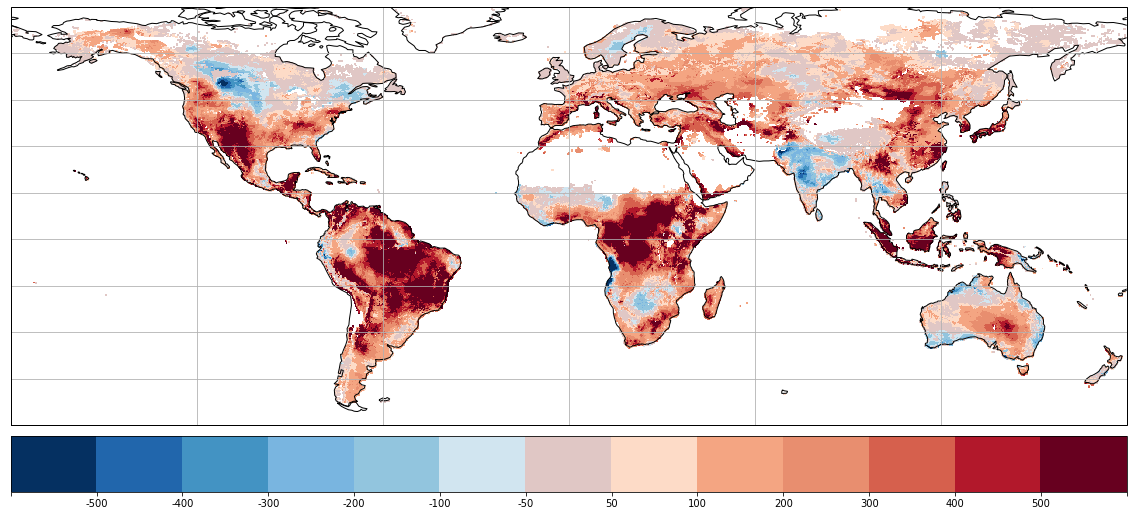

In [5]:
with rio.open('../fromJohn_Idaho/nighthourstrend.nc') as src:
    print(src.profile)
    vpd=src.read(1)


vpd_data = vpd
template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
with rio.open(template) as src:
    meta = src.meta
    print(meta)

o_tform = meta['transform']


tform = o_tform.translation(-180,-15) * o_tform

# dif_affine = np.array(meta['transform']) - [0, 0, 0, 0, 0, 0]
# print(dif_affine)

#num_x = meta['width']
#num_y = meta['height']

vnum_x = vpd_data.shape[1]
vnum_y = vpd_data.shape[0]

# incorporate aggregation factor
vtlon = np.linspace(tform.c - tform.a, tform.c+vnum_x*tform.a, vnum_x)
vtlat = np.linspace(tform.f - tform.e, tform.f+vnum_y*tform.e, vnum_y)
vlon2d, vlat2d = np.meshgrid(vtlon, vtlat)

# make data into xarray with location
v_xdata = xr.DataArray(vpd_data, coords=[vtlat, vtlon], dims=['lat', 'lon'])
v_xdata = xr.where(v_xdata == 0, np.nan, v_xdata)
v_xdata = xr.where(v_xdata == -9999, np.nan, v_xdata)

# fig, ax = plt.subplots(1,1, projection=ccrs.PlateCarree(central_longitude=0))
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines()
ax.gridlines()

del colors
# colors = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']
# colors= [(100,0,20),
#          (103,0,31),(178,24,43),(214,96,77),(244,165,130),(253,219,199),(247,247,247),(209,229,240),(146,197,222),(67,147,195),(33,102,172),(5,48,97),
#          (12,35,61)]
# colors = list(np.array(colors)/255)

colors = [(103,0,31),(178,24,43),(214,96,77),(232, 142, 111),
          (244,165,130),(253,219,199),(224, 199, 197),(209,229,240),(146,197,222), (121, 181, 224),
          (67,147,195),(33,102,172),(5,48,97)]
colors = list(np.array(colors)/255)

colors.reverse()
cmap = matplotlib.colors.ListedColormap(colors)
bounds = [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500]
bounds_labels = [''] + bounds + ['']
bounds = [-600] + bounds + [600]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)

cf4 = v_xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
ax.set_ylim(-60,75)

# ax.set_title('NIGHTTIME %')

cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                   boundaries=bounds, 
                   norm=norm, 
                   cmap=cmap,
                   ticks=bounds)
cb4.set_ticklabels(bounds_labels)

plt.savefig(r'C:\users\jomc9287\desktop\nighthourstrend.png')

In [19]:
def save_vpd_fig(fname, bounds_list, raster_folder):
    
    with rio.open(fname) as src:
        print(src.profile)
        vpd=src.read(1)
    
    

    vpd_data = vpd
    template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
    with rio.open(template) as src:
        meta = src.meta
        print(meta)

    o_tform = meta['transform']
    
    tform = o_tform.translation(-180,-15) * o_tform

    # dif_affine = np.array(meta['transform']) - [0, 0, 0, 0, 0, 0]
    # print(dif_affine)

    #num_x = meta['width']
    #num_y = meta['height']

    vnum_x = vpd_data.shape[1]
    vnum_y = vpd_data.shape[0]

    # incorporate aggregation factor
    vtlon = np.linspace(tform.c - tform.a, tform.c+vnum_x*tform.a, vnum_x)
    vtlat = np.linspace(tform.f - tform.e, tform.f+vnum_y*tform.e, vnum_y)
    vlon2d, vlat2d = np.meshgrid(vtlon, vtlat)

    # make data into xarray with location
    v_xdata = xr.DataArray(vpd_data, coords=[vtlat, vtlon], dims=['lat', 'lon'])
    v_xdata = xr.where(v_xdata == 0, np.nan, v_xdata)
    v_xdata = xr.where(v_xdata == -9999, np.nan, v_xdata)
    
    if 'annualVPDtrend' in fname:
        v_xdata/=10

    # fig, ax = plt.subplots(1,1, projection=ccrs.PlateCarree(central_longitude=0))
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_global()
    ax.coastlines()
    #ax.gridlines()


    colors = [(103,0,31),(178,24,43),(214,96,77),(232, 142, 111),
              (244,165,130),(253,219,199),(240, 235, 235),(209,229,240),(146,197,222), (121, 181, 224),
              (67,147,195),(33,102,172),(5,48,97)]
    colors = list(np.array(colors)/255)

    colors.reverse()
    cmap = matplotlib.colors.ListedColormap(colors)
    #bounds = [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500]
    bounds = bounds_list
    bounds_labels = [''] + bounds + ['']
    bounds = [-600] + bounds + [600]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)

    cf4 = v_xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
    ax.set_ylim(-60, 75)
    
    # ax.set_title('NIGHTTIME %')

    cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                       boundaries=bounds, 
                       norm=norm, 
                       cmap=cmap,
                       ticks=bounds)
    cb4.set_ticklabels(bounds_labels)

    fig_name = os.path.basename(fname).split('.')[0]
    plt.savefig(f'../fromJohn_Idaho/{fig_name}.png')

In [7]:
vpd_folder = '../fromJohn_Idaho'
vpd_files = glob(vpd_folder + '/*.nc')
vpd_files

['../fromJohn_Idaho\\annualpercentVPDmintrend.nc',
 '../fromJohn_Idaho\\annualVPDMINtrend.nc',
 '../fromJohn_Idaho\\annualVPDtrend.nc',
 '../fromJohn_Idaho\\conseqnightstrend.nc',
 '../fromJohn_Idaho\\dayhourstrend.nc',
 '../fromJohn_Idaho\\nighthourstrend.nc',
 '../fromJohn_Idaho\\nightstrend.nc']

{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32768.0, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875)}
{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1441, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32768.0, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875)}
{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
{'driver': 

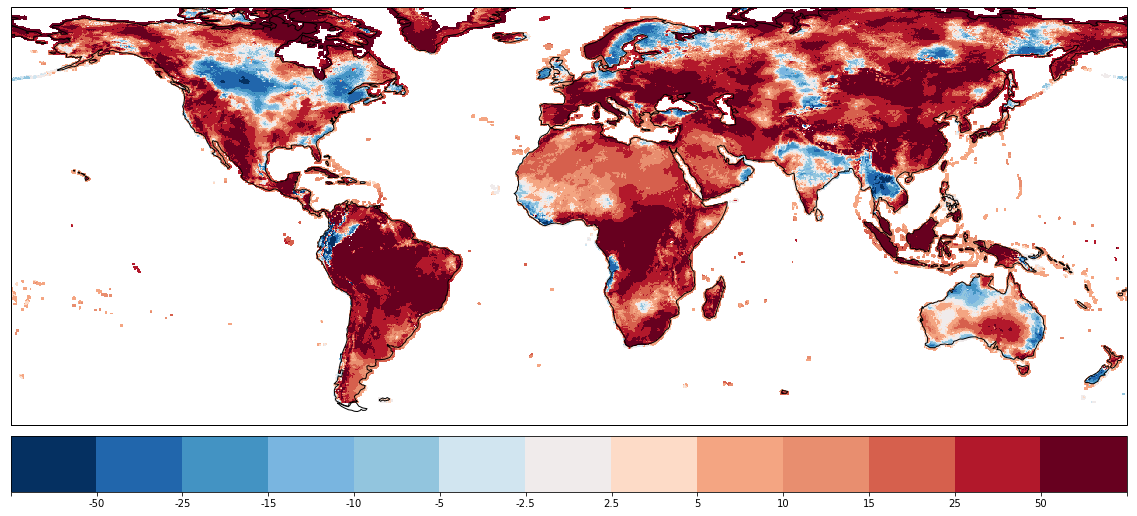

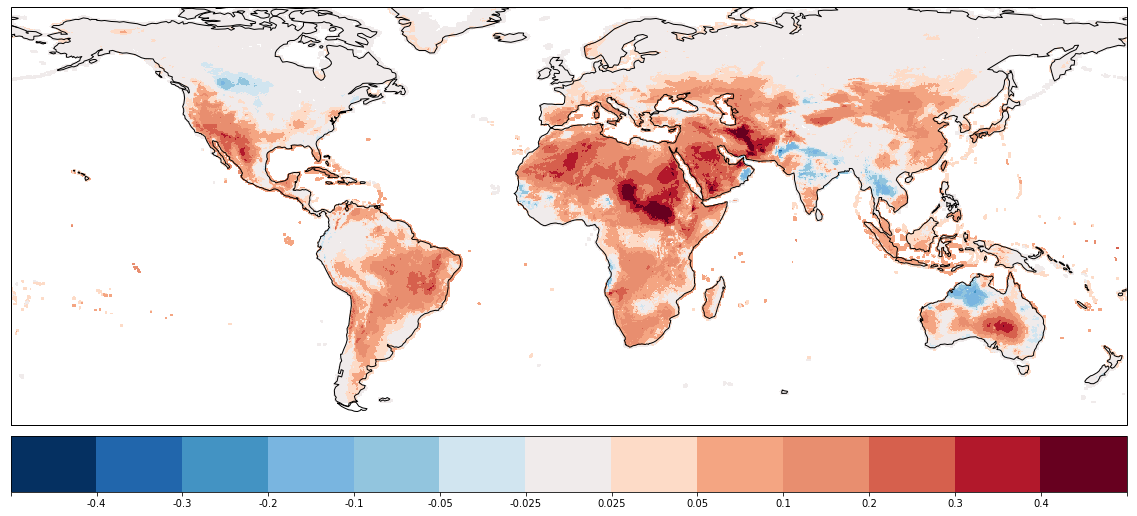

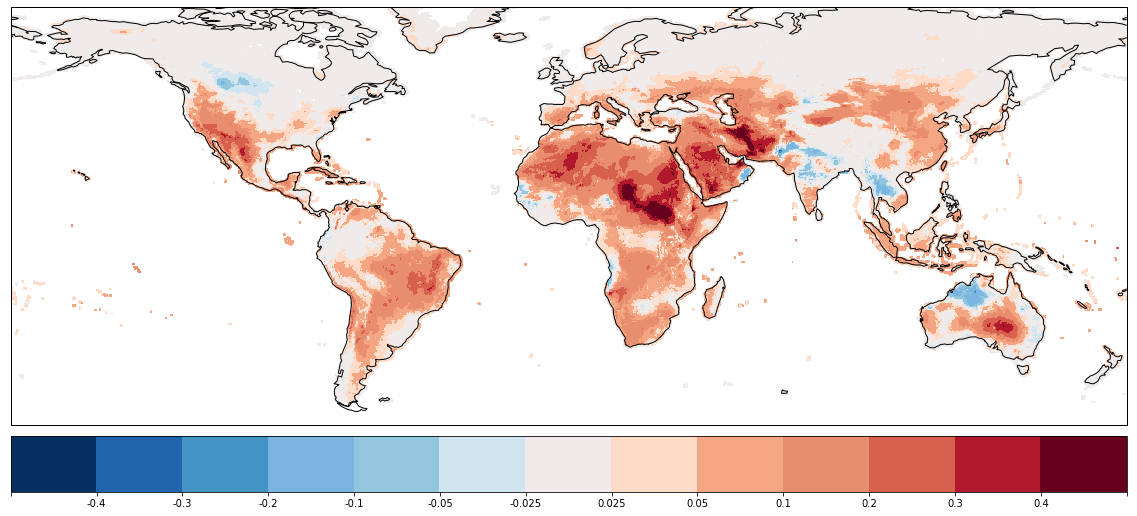

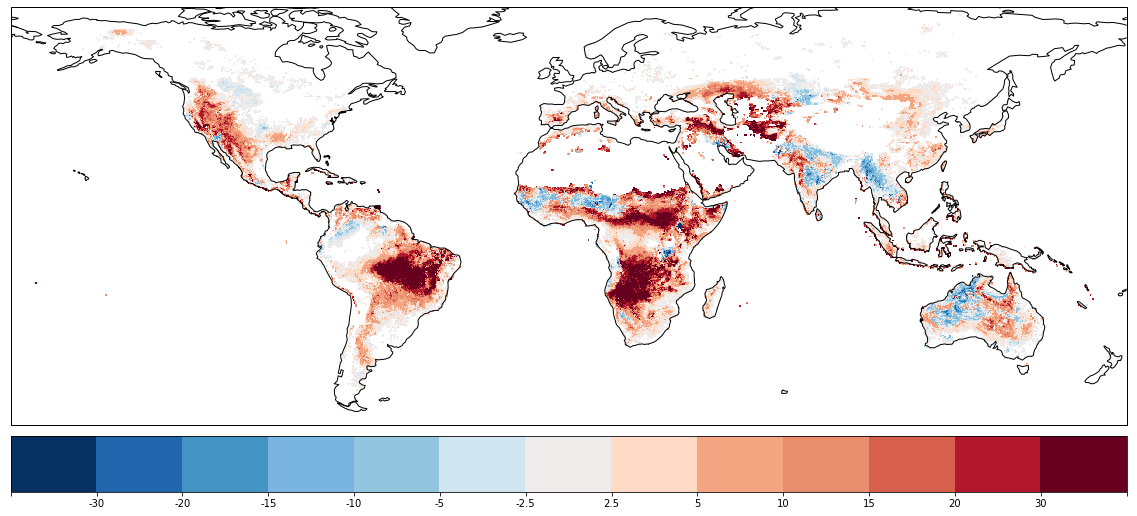

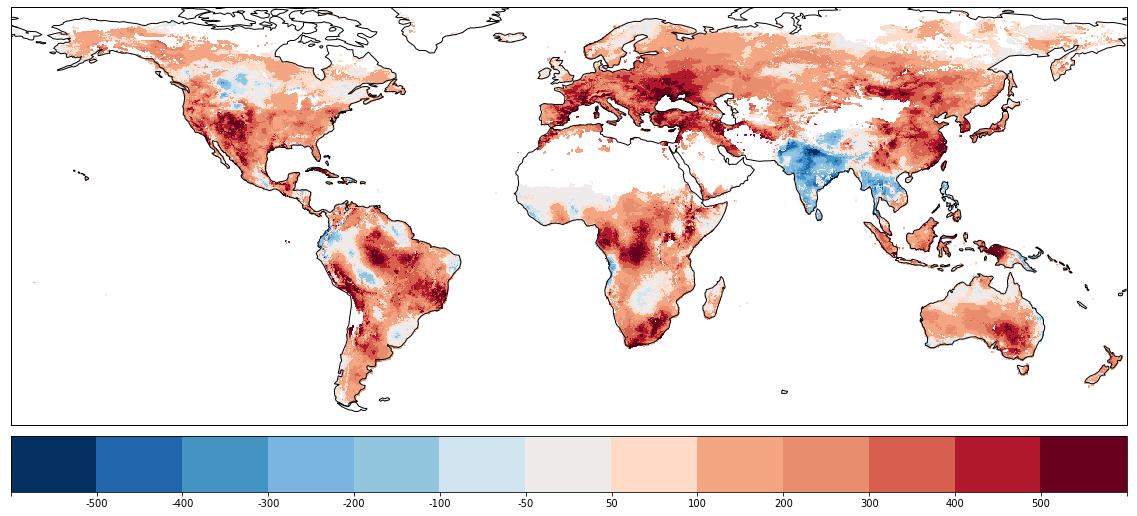

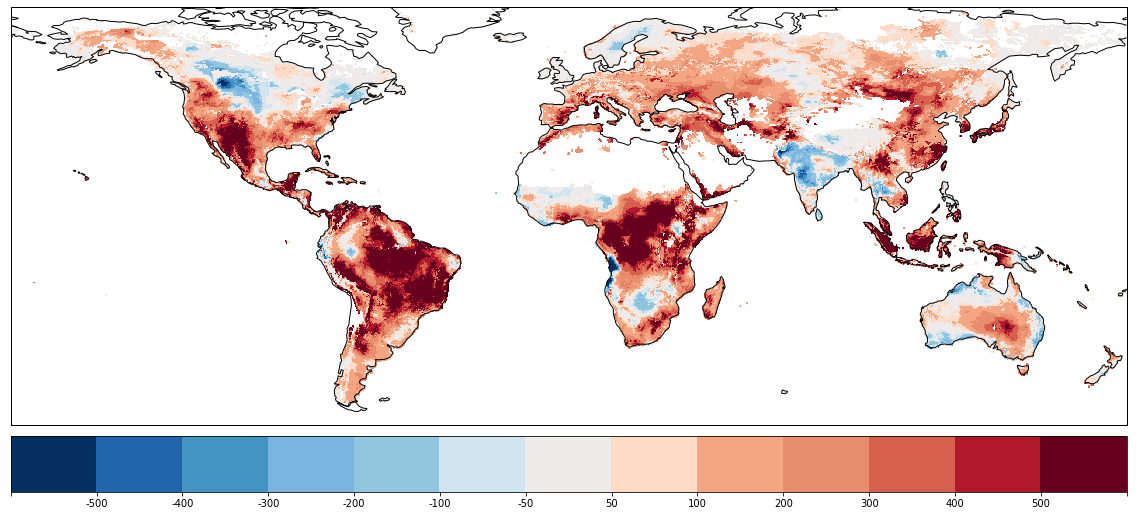

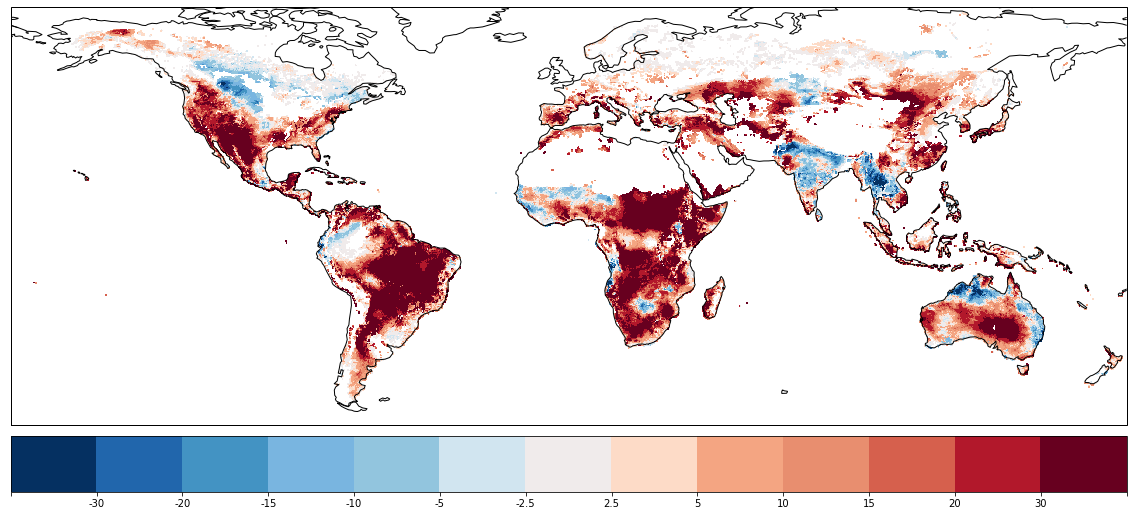

In [20]:
# bounds for files in glob
bounds_entries = [[-50,-25,-15,-10,-5,-2.5,2.5,5,10,15,25,50],
                  [-0.4,-0.3,-0.2,-0.1,-0.05, -0.025, 0.025, 0.05,0.1,0.2, 0.3, 0.4],
                  [-0.4,-0.3, -0.2,-0.1,-0.05, -0.025, 0.025, 0.05,0.1,0.2,0.3, 0.4],
                  [-30,-20,-15,-10,-5,-2.5,2.5,5,10,15,20,30],
                  [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500], 
                  [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500],
                  [-30,-20,-15,-10,-5,-2.5,2.5,5,10,15,20,30] ]


for f, b in zip(vpd_files, bounds_entries):
    save_vpd_fig(f,b,raster_folder)

In [14]:
some_dict = {}
for k,v in zip([os.path.basename(_).split('.')[0] for _ in vpd_files], bounds_entries):
    some_dict[k]=v
    
some_dict

{'annualpercentVPDmintrend': [-50,
  -25,
  -15,
  -10,
  -5,
  -2.5,
  2.5,
  5,
  10,
  15,
  25,
  50],
 'annualVPDMINtrend': [-0.4,
  -0.3,
  -0.2,
  -0.1,
  -0.05,
  -0.025,
  0.025,
  0.05,
  0.1,
  0.2,
  0.3,
  0.4],
 'annualVPDtrend': [-0.4,
  -0.3,
  -0.2,
  -0.1,
  -0.05,
  -0.025,
  0.025,
  0.05,
  0.1,
  0.2,
  0.3,
  0.4],
 'conseqnightstrend': [-30, -20, -15, -10, -5, -2.5, 2.5, 5, 10, 15, 20, 30],
 'dayhourstrend': [-500,
  -400,
  -300,
  -200,
  -100,
  -50,
  50,
  100,
  200,
  300,
  400,
  500],
 'nighthourstrend': [-500,
  -400,
  -300,
  -200,
  -100,
  -50,
  50,
  100,
  200,
  300,
  400,
  500],
 'nightstrend': [-30, -20, -15, -10, -5, -2.5, 2.5, 5, 10, 15, 20, 30]}

In [16]:
for f in vpd_files:
    with rio.open(f) as src:
        a = src.read()
        print(a.min(), a.max())

-683333.4 20085478.0
-9999.0 0.6781601
-9999.0 6.7816005
-9999.0 203.0006
-9999.0 1477.2812
-9999.0 2091.0586
-9999.0 214.68056
